# Figure 3 (Mixed Model Analysis)

In [1]:
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.formula.api as smf

In [2]:
# Replace with the path to where you store data
DATA_PATH = "../../cnt-data/"

# Set up the seaborn style
sns.set_style("whitegrid")

In [3]:
def get_patient_hup_ids(directory):
    # List all files in the directory
    files = os.listdir(directory)

    # Filter out files based on the given pattern and extract patient_hup_id as integers
    patient_hup_ids = [
        int(f.split("_")[1].split(".")[0]) for f in files if f.startswith("HUP_")
    ]

    return patient_hup_ids


TABLES_PATH = os.path.join(DATA_PATH, "giant_new_tables")
completed_hup_ids = get_patient_hup_ids(TABLES_PATH)
completed_hup_ids.sort()

## Pre first seizure data only

In [4]:
def get_relevant_data(df):
    # Find the first seizure time
    first_seizure_time = df[df["had_seizure"] >= 1]["emu_minute"].min()

    # Select the data for the period before the first seizure
    pre_seizure_data = df[
        (df["emu_minute"] >= 10) & (df["emu_minute"] < first_seizure_time - 20)
    ]

    # Return the combined data
    return pre_seizure_data


# Prepare dataframes for all patients
dfs = []
for patient_hup_id in completed_hup_ids:
    patient_features_df = pd.read_csv(
        os.path.join(TABLES_PATH, f"HUP_{str(patient_hup_id)}.csv")
    )

    # Only keep emu_minute, synchrony_broadband,med_sum_no_lorazepam_raw, and had_seizure columns
    patient_features_df = patient_features_df[
        [
            "synchrony_broadband",
            "med_sum_no_lorazepam_raw",
            "ad_ratio",
            "had_seizure",
            "emu_minute",
        ]
    ]

    # Add a column for patient_hup_id
    patient_features_df["patient_hup_id"] = patient_hup_id

    dfs.append(get_relevant_data(patient_features_df))

# Combine them into one dataframe
all_data = pd.concat(dfs).reset_index(drop=True)
# drop rows with any missing values
all_data = all_data.dropna()
# Reset the index
all_data = all_data.reset_index(drop=True)

In [5]:
# Load taper_annotations.csv from the data directory
taper_df = pd.read_csv(os.path.join(DATA_PATH, "taper_annotations.csv"))
# Drop rows with any missing values in taper_start_hr
taper_df = taper_df.dropna(subset=["taper_start_hr"])
# Drop the reinit_start_hr column
taper_df = taper_df.drop(columns=["reinit_start_hr"]).reset_index(drop=True)
taper_df

,hup_id,taper_start_hr
0,140,80.0
1,142,75.0
2,143,75.0
3,145,100.0
4,151,80.0
5,152,120.0
6,160,100.0
7,163,75.0
8,164,60.0
9,165,100.0


In [6]:
from sklearn.preprocessing import StandardScaler


# Define the function to get relevant data before the first seizure
def get_relevant_data(df, taper_start_hr):
    # Find the first seizure time
    first_seizure_time = df[df["had_seizure"] >= 1]["emu_minute"].min()

    # Select the data for the period before the first seizure
    pre_seizure_data = df[
        (taper_start_hr * 60 - 60 <= df["emu_minute"])
        & (df["emu_minute"] < taper_start_hr * 60 + 60)
    ].copy()  # Use .copy() to avoid SettingWithCopyWarning

    return pre_seizure_data


# Prepare dataframes for all patients
dfs = []

# Loop over all patients
for i, row in taper_df.iterrows():
    patient_hup_id = int(row["hup_id"])
    taper_start_hr = row["taper_start_hr"]
    patient_features_df = pd.read_csv(
        os.path.join(TABLES_PATH, f"HUP_{str(patient_hup_id)}.csv")
    )

    # Only keep emu_minute, synchrony_broadband, med_sum_no_lorazepam_raw, and had_seizure columns
    patient_features_df = patient_features_df[
        [
            "synchrony_broadband",
            "med_sum_no_lorazepam_raw",
            "ad_ratio",
            "had_seizure",
            "emu_minute",
        ]
    ]

    # Add a column for patient_hup_id
    patient_features_df["patient_hup_id"] = patient_hup_id

    # Apply get_relevant_data to filter pre-first-seizure data
    pre_seizure_data = get_relevant_data(patient_features_df, taper_start_hr)

    # Append to list
    dfs.append(pre_seizure_data)

# Combine all filtered data into one dataframe
all_pre_seizure_data = pd.concat(dfs).reset_index(drop=True)

# Drop rows with any missing values
all_pre_seizure_data = all_pre_seizure_data.dropna()

# Now standardize the relevant columns (synchrony_broadband, ad_ratio, emu_minute)
scaler = StandardScaler()
all_pre_seizure_data[["synchrony_broadband", "ad_ratio", "emu_minute"]] = (
    scaler.fit_transform(
        all_pre_seizure_data[["synchrony_broadband", "ad_ratio", "emu_minute"]]
    )
)

# Prepare the mixed model using the filtered and standardized data
model = smf.mixedlm(
    "med_sum_no_lorazepam_raw ~ synchrony_broadband + emu_minute + ad_ratio",
    all_pre_seizure_data,
    groups=all_pre_seizure_data["patient_hup_id"],
)

# Fit the model
result = model.fit()
print(result.summary())

                Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: med_sum_no_lorazepam_raw
No. Observations: 959     Method:             REML                    
No. Groups:       16      Scale:              0.0000                  
Min. group size:  59      Log-Likelihood:     3400.1501               
Max. group size:  60      Converged:          Yes                     
Mean group size:  59.9                                                
-----------------------------------------------------------------------
                       Coef.   Std.Err.     z     P>|z|  [0.025  0.975]
-----------------------------------------------------------------------
Intercept               0.407     0.110    3.698  0.000   0.191   0.623
synchrony_broadband    -0.001     0.000   -3.384  0.001  -0.002  -0.000
emu_minute             -0.367     0.006  -62.267  0.000  -0.378  -0.355
ad_ratio               -0.001     0.000   -3.155  0.002  -0.002  -0.000
Group Var       

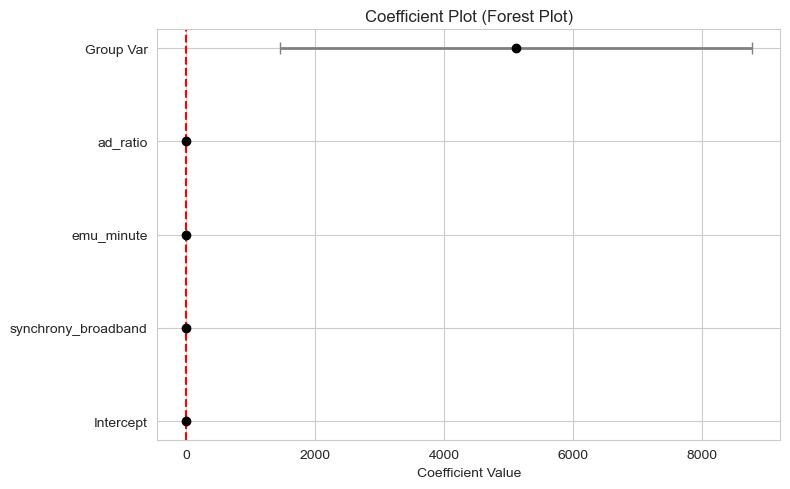

In [7]:
# Extracting the coefficients, confidence intervals, and standard errors
params = result.params
conf_int = result.conf_int()
errors = result.bse

# Coefficients and their confidence intervals
coef_names = params.index
coef_values = params.values
lower_ci = conf_int[0].values
upper_ci = conf_int[1].values

# Create the plot
fig, ax = plt.subplots(figsize=(8, 5))

# Plot the coefficients as points
ax.errorbar(
    coef_values,
    coef_names,
    xerr=[
        np.array(coef_values) - np.array(lower_ci),
        np.array(upper_ci) - np.array(coef_values),
    ],
    fmt="o",
    color="black",
    ecolor="gray",
    elinewidth=2,
    capsize=4,
)

# Add a vertical line at x=0 for reference
ax.axvline(x=0, color="red", linestyle="--")

# Labeling the plot
ax.set_xlabel("Coefficient Value")
ax.set_title("Coefficient Plot (Forest Plot)")

# Show plot
plt.tight_layout()
plt.show()

## All data

In [8]:
# Prepare dataframes for all patients
dfs = []
for patient_hup_id in completed_hup_ids:
    patient_features_df = pd.read_csv(
        os.path.join(TABLES_PATH, f"HUP_{str(patient_hup_id)}.csv")
    )

    # Only keep emu_minute, synchrony_broadband,med_sum_no_lorazepam_raw, and had_seizure columns
    patient_features_df = patient_features_df[
        [
            "emu_minute",
            "synchrony_broadband",
            "med_sum_no_lorazepam_raw",
            "time_since_last_seizure",
            "ad_ratio",
        ]
    ]

    # Add a column for patient_hup_id
    patient_features_df["patient_hup_id"] = patient_hup_id
    dfs.append(patient_features_df)


# Combine them into one dataframe
all_data = pd.concat(dfs).reset_index(drop=True)
# drop rows with any missing values
all_data = all_data.dropna()
# Reset the index
all_data = all_data.reset_index(drop=True)

In [9]:
# Prepare the model
model = smf.mixedlm(
    "med_sum_no_lorazepam_raw ~ synchrony_broadband + time_since_last_seizure + emu_minute + ad_ratio",
    all_data,
    groups=all_data["patient_hup_id"],
)

# Fit the model
result = model.fit()
print(result.summary())

# print the r^2 value
# print("r^2 value:", result.rsquared)

                Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: med_sum_no_lorazepam_raw
No. Observations: 222360  Method:             REML                    
No. Groups:       68      Scale:              0.0299                  
Min. group size:  2       Log-Likelihood:     74286.6000              
Max. group size:  9111    Converged:          Yes                     
Mean group size:  3270.0                                              
----------------------------------------------------------------------
                           Coef.  Std.Err.    z    P>|z| [0.025 0.975]
----------------------------------------------------------------------
Intercept                   0.289    0.028  10.299 0.000  0.234  0.344
synchrony_broadband        -0.117    0.006 -20.302 0.000 -0.128 -0.106
time_since_last_seizure    -0.000    0.000 -22.043 0.000 -0.000 -0.000
emu_minute                  0.000    0.000  26.732 0.000  0.000  0.000
ad_ratio               

In [10]:
# Get the fitted values based solely on fixed effects
# (For a linear model, these are the predictions; ensure that random effects are excluded)
fixed_effects_pred = result.fittedvalues
var_fixed = np.var(fixed_effects_pred)

# Extract the random effects variance (for a random intercept model, this is a single value)
# Note: If your model has more complex random structures, you may need to sum across components
var_random = result.cov_re.iloc[0, 0]

# Get the residual variance (scale parameter)
var_residual = result.scale

# Compute marginal R²
marginal_R2 = var_fixed / (var_fixed + var_random + var_residual)
print("Marginal R²:", marginal_R2)

Marginal R²: 0.34600239764815865


In [11]:
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Create a dataframe with the predictors
X = all_data[
    ["synchrony_broadband", "time_since_last_seizure", "emu_minute", "ad_ratio"]
]
# Add an intercept term
X = sm.add_constant(X)

# Calculate VIF for each feature
vif_data = pd.DataFrame()
vif_data["feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
print(vif_data)

                   feature       VIF
0                    const  6.340126
1      synchrony_broadband  1.001905
2  time_since_last_seizure  1.379494
3               emu_minute  1.382592
4                 ad_ratio  1.002397


In [12]:
result.params.values

array([ 2.88600588e-01, -1.16801318e-01, -5.92810757e-06,  4.76830166e-06,
       -1.40795176e-03,  1.77022785e+00])

### With standarization

In [13]:
from sklearn.preprocessing import StandardScaler

# Prepare dataframes for all patients
dfs = []
for patient_hup_id in completed_hup_ids:
    patient_features_df = pd.read_csv(
        os.path.join(TABLES_PATH, f"HUP_{str(patient_hup_id)}.csv")
    )

    # Only keep emu_minute, synchrony_broadband, med_sum_no_lorazepam_raw, and had_seizure columns
    patient_features_df = patient_features_df[
        [
            "emu_minute",
            "synchrony_broadband",
            "med_sum_no_lorazepam_raw",
            "time_since_last_seizure",
            "ad_ratio",
        ]
    ]

    # Add a column for patient_hup_id
    patient_features_df["patient_hup_id"] = patient_hup_id
    dfs.append(patient_features_df)

# Combine them into one dataframe
all_data = pd.concat(dfs).reset_index(drop=True)

# Drop rows with any missing values
all_data = all_data.dropna()

# Reset the index
all_data = all_data.reset_index(drop=True)

# Standardize continuous variables
scaler = StandardScaler()

# Standardize 'synchrony_broadband', 'time_since_last_seizure', 'emu_minute', and 'ad_ratio'
all_data[
    ["synchrony_broadband", "time_since_last_seizure", "emu_minute", "ad_ratio"]
] = scaler.fit_transform(
    all_data[
        ["synchrony_broadband", "time_since_last_seizure", "emu_minute", "ad_ratio"]
    ]
)

# Prepare the model
model = smf.mixedlm(
    "med_sum_no_lorazepam_raw ~ synchrony_broadband + time_since_last_seizure + emu_minute + ad_ratio",
    all_data,
    groups=all_data["patient_hup_id"],
)

# Fit the model
result = model.fit()
print(result.summary())

                Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: med_sum_no_lorazepam_raw
No. Observations: 222360  Method:             REML                    
No. Groups:       68      Scale:              0.0299                  
Min. group size:  2       Log-Likelihood:     74301.5488              
Max. group size:  9111    Converged:          Yes                     
Mean group size:  3270.0                                              
----------------------------------------------------------------------
                           Coef.  Std.Err.    z    P>|z| [0.025 0.975]
----------------------------------------------------------------------
Intercept                   0.310    0.028  11.092 0.000  0.255  0.365
synchrony_broadband        -0.019    0.001 -20.302 0.000 -0.021 -0.017
time_since_last_seizure    -0.017    0.001 -22.043 0.000 -0.019 -0.016
emu_minute                  0.027    0.001  26.732 0.000  0.025  0.029
ad_ratio               

In [14]:
# Get the fitted values based solely on fixed effects
# (For a linear model, these are the predictions; ensure that random effects are excluded)
fixed_effects_pred = result.fittedvalues
var_fixed = np.var(fixed_effects_pred)

# Extract the random effects variance (for a random intercept model, this is a single value)
# Note: If your model has more complex random structures, you may need to sum across components
var_random = result.cov_re.iloc[0, 0]

# Get the residual variance (scale parameter)
var_residual = result.scale

# Compute marginal R²
marginal_R2 = var_fixed / (var_fixed + var_random + var_residual)
print("Marginal R²:", marginal_R2)

# Compute conditional R²:
conditional_R2 = (var_fixed + var_random) / (var_fixed + var_random + var_residual)
print("Conditional R²:", conditional_R2)

Marginal R²: 0.3460023976466922
Conditional R²: 0.7639192018101707


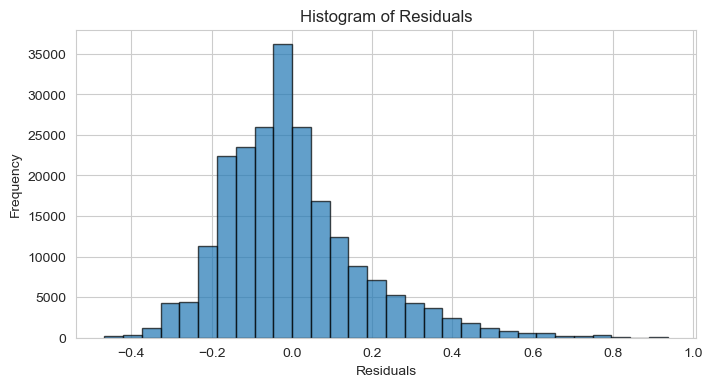

<Figure size 800x400 with 0 Axes>

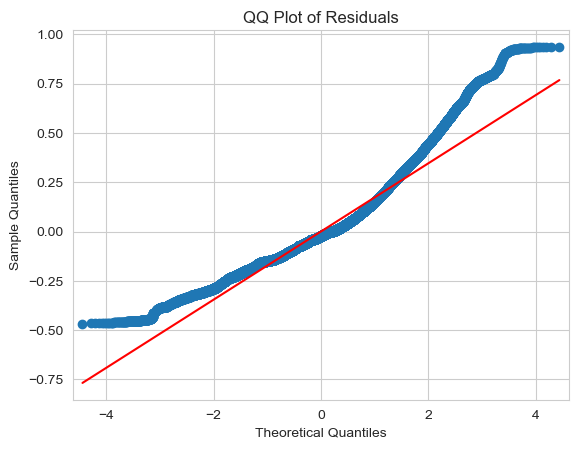

In [15]:
import statsmodels.api as sm

# Extract residuals from the fitted model
resid = result.resid

# Histogram of residuals
plt.figure(figsize=(8, 4))
plt.hist(resid, bins=30, edgecolor="k", alpha=0.7)
plt.xlabel("Residuals")
plt.ylabel("Frequency")
plt.title("Histogram of Residuals")
plt.show()

# QQ plot of residuals
plt.figure(figsize=(8, 4))
sm.qqplot(resid, line="s")
plt.title("QQ Plot of Residuals")
plt.show()

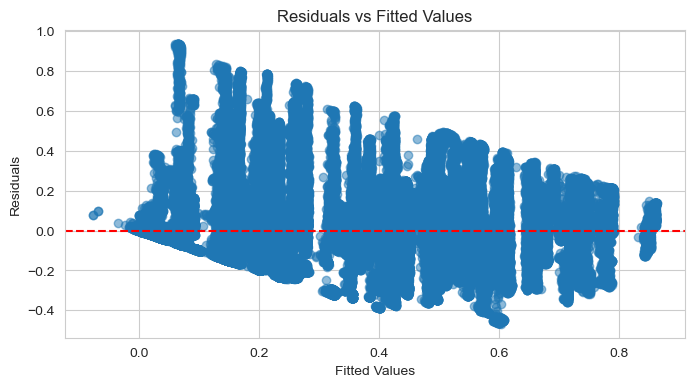

In [16]:
# Fitted values from the model
fitted = result.fittedvalues

plt.figure(figsize=(8, 4))
plt.scatter(fitted, resid, alpha=0.5)
plt.xlabel("Fitted Values")
plt.ylabel("Residuals")
plt.title("Residuals vs Fitted Values")
plt.axhline(y=0, color="r", linestyle="--")
plt.show()

#### Transformation

In [17]:
import os
import numpy as np
import pandas as pd
import statsmodels.formula.api as smf
from sklearn.preprocessing import StandardScaler

# Prepare dataframes for all patients
dfs = []
for patient_hup_id in completed_hup_ids:
    patient_features_df = pd.read_csv(
        os.path.join(TABLES_PATH, f"HUP_{str(patient_hup_id)}.csv")
    )

    # Only keep emu_minute, synchrony_broadband, med_sum_no_lorazepam_raw, time_since_last_seizure, and ad_ratio columns
    patient_features_df = patient_features_df[
        [
            "emu_minute",
            "synchrony_broadband",
            "med_sum_no_lorazepam_raw",
            "time_since_last_seizure",
            "ad_ratio",
        ]
    ]

    # Add a column for patient_hup_id
    patient_features_df["patient_hup_id"] = patient_hup_id
    dfs.append(patient_features_df)

# Combine them into one dataframe
all_data = pd.concat(dfs).reset_index(drop=True)

# Drop rows with any missing values and reset the index
all_data = all_data.dropna().reset_index(drop=True)

# Log-transform the outcome variable (adding 1 to avoid log(0))
all_data["med_sum_no_lorazepam_raw"] = np.log(all_data["med_sum_no_lorazepam_raw"] + 1)

# Standardize continuous predictor variables
scaler = StandardScaler()
all_data[
    ["synchrony_broadband", "time_since_last_seizure", "emu_minute", "ad_ratio"]
] = scaler.fit_transform(
    all_data[
        ["synchrony_broadband", "time_since_last_seizure", "emu_minute", "ad_ratio"]
    ]
)

# Prepare the model using the log-transformed outcome
model = smf.mixedlm(
    "med_sum_no_lorazepam_raw ~ synchrony_broadband + time_since_last_seizure + emu_minute + ad_ratio",
    all_data,
    groups=all_data["patient_hup_id"],
)

# Fit the model
result = model.fit()
print(result.summary())

                Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: med_sum_no_lorazepam_raw
No. Observations: 222360  Method:             REML                    
No. Groups:       68      Scale:              0.0158                  
Min. group size:  2       Log-Likelihood:     145149.8279             
Max. group size:  9111    Converged:          Yes                     
Mean group size:  3270.0                                              
----------------------------------------------------------------------
                           Coef.  Std.Err.    z    P>|z| [0.025 0.975]
----------------------------------------------------------------------
Intercept                   0.249    0.021  11.885 0.000  0.208  0.291
synchrony_broadband        -0.012    0.001 -18.332 0.000 -0.014 -0.011
time_since_last_seizure    -0.013    0.001 -23.325 0.000 -0.014 -0.012
emu_minute                  0.022    0.001  29.783 0.000  0.020  0.023
ad_ratio               

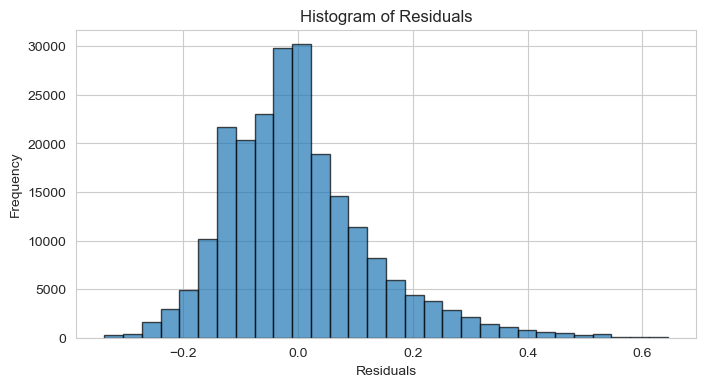

<Figure size 800x400 with 0 Axes>

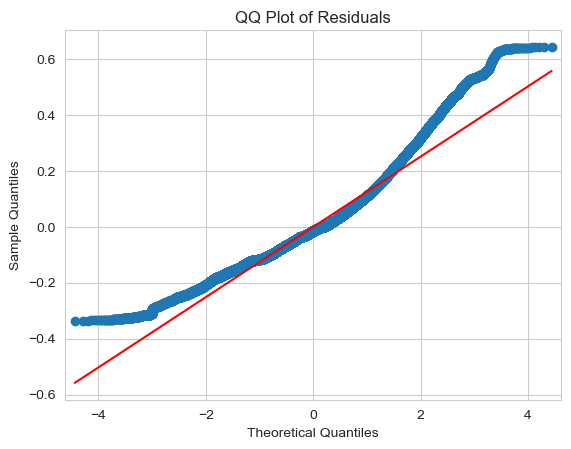

In [18]:
import statsmodels.api as sm

# Extract residuals from the fitted model
resid = result.resid

# Histogram of residuals
plt.figure(figsize=(8, 4))
plt.hist(resid, bins=30, edgecolor="k", alpha=0.7)
plt.xlabel("Residuals")
plt.ylabel("Frequency")
plt.title("Histogram of Residuals")
plt.show()

# QQ plot of residuals
plt.figure(figsize=(8, 4))
sm.qqplot(resid, line="s")
plt.title("QQ Plot of Residuals")
plt.show()

## Figure 3 (A) - Coefficients of Linear Mixed Model

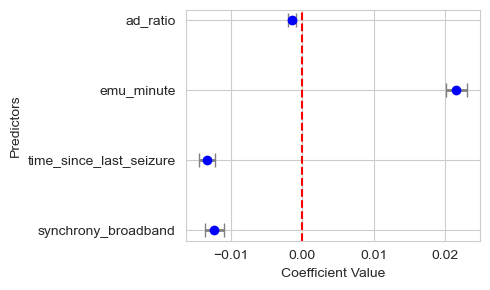

In [19]:
# Drop Group Var and Intercept from the results
coefficients = result.params.drop(["Group Var", "Intercept"]).values
predictors = result.params.drop(["Group Var", "Intercept"]).index
std_errors = result.bse.drop(["Group Var", "Intercept"]).values

# For a 95% confidence interval, z value is approximately 1.96
z_value = 1.96
conf_intervals = [
    (coef - z_value * se, coef + z_value * se)
    for coef, se in zip(coefficients, std_errors)
]

# Calculate lower and upper errors for each coefficient
lower_errors = [
    coef - ci_low for coef, (ci_low, ci_high) in zip(coefficients, conf_intervals)
]
upper_errors = [
    ci_high - coef for coef, (ci_low, ci_high) in zip(coefficients, conf_intervals)
]


# Create the coefficient plot
plt.figure(figsize=(5, 3))
for idx, (coef, predictor) in enumerate(zip(coefficients, predictors)):
    plt.errorbar(
        coef,
        idx,
        xerr=[[lower_errors[idx]], [upper_errors[idx]]],
        fmt="o",
        color="blue",
        ecolor="gray",
        elinewidth=2,
        capsize=5,
    )

# Formatting
plt.yticks(range(len(predictors)), predictors)
plt.axvline(0, color="red", linestyle="--")  # Add a vertical line for 0
plt.xlabel("Coefficient Value")
plt.ylabel("Predictors")
# plt.title("Mixed Model Coefficients with 95% Confidence Intervals")
plt.tight_layout()
plt.show()

## Figure 3 (B) - Relative Importance from Dominance Analysis

#### Without standardization

In [20]:
# Number of bootstraps
n_boots = 1000

# List of predictors
predictors = [
    "synchrony_broadband",
    "time_since_last_seizure",
    "emu_minute",
    "ad_ratio",
]
coefficients = {pred: [] for pred in predictors}

for _ in range(n_boots):
    # Sample data with replacement
    boot_data = all_data.sample(frac=1, replace=True)

    # Fit model on bootstrap sample
    model = smf.mixedlm(
        "med_sum_no_lorazepam_raw ~ synchrony_broadband + time_since_last_seizure + emu_minute + ad_ratio",
        boot_data,
        groups=boot_data["patient_hup_id"],
    )
    result = model.fit()

    # Store coefficients
    for pred in predictors:
        coefficients[pred].append(result.params[pred])

# Calculate variability (standard deviation) of coefficients for each predictor
relative_importance = {pred: np.std(coefficients[pred]) for pred in predictors}

# Compute standard error for each predictor
standard_errors = {
    pred: std / np.sqrt(n_boots) for pred, std in relative_importance.items()
}

# Sort the predictors based on relative importance
sorted_predictors = sorted(
    relative_importance, key=relative_importance.get, reverse=True
)

# Visualization
plt.figure(figsize=(6, 3))
plt.bar(
    sorted_predictors,
    [relative_importance[pred] for pred in sorted_predictors],
    yerr=[standard_errors[pred] for pred in sorted_predictors],
    capsize=10,
)
plt.ylabel("Standard Deviation of Coefficients")
plt.title("Relative Importance of Predictors with Error Bars")
plt.xticks(rotation=45)  # Rotate predictor names for better readability
plt.show()

KeyboardInterrupt: 

#### With standardization

In [ ]:
from sklearn.preprocessing import StandardScaler

# Number of bootstraps
n_boots = 1000

# List of predictors
predictors = [
    "synchrony_broadband",
    "time_since_last_seizure",
    "emu_minute",
    "ad_ratio",
]
coefficients = {pred: [] for pred in predictors}

# Standardize the data before bootstrapping
scaler = StandardScaler()
all_data[
    ["synchrony_broadband", "time_since_last_seizure", "emu_minute", "ad_ratio"]
] = scaler.fit_transform(
    all_data[
        ["synchrony_broadband", "time_since_last_seizure", "emu_minute", "ad_ratio"]
    ]
)

for _ in range(n_boots):
    # Sample data with replacement
    boot_data = all_data.sample(frac=1, replace=True)

    # Fit model on bootstrap sample
    model = smf.mixedlm(
        "med_sum_no_lorazepam_raw ~ synchrony_broadband + time_since_last_seizure + emu_minute + ad_ratio",
        boot_data,
        groups=boot_data["patient_hup_id"],
    )
    result = model.fit()

    # Store coefficients
    for pred in predictors:
        coefficients[pred].append(result.params[pred])

# Calculate variability (standard deviation) of coefficients for each predictor
relative_importance = {pred: np.std(coefficients[pred]) for pred in predictors}

# Compute standard error for each predictor
standard_errors = {
    pred: std / np.sqrt(n_boots) for pred, std in relative_importance.items()
}

# Sort the predictors based on relative importance
sorted_predictors = sorted(
    relative_importance, key=relative_importance.get, reverse=True
)

# Visualization
plt.figure(figsize=(6, 3))
plt.bar(
    sorted_predictors,
    [relative_importance[pred] for pred in sorted_predictors],
    yerr=[standard_errors[pred] for pred in sorted_predictors],
    capsize=10,
)
plt.ylabel("Standard Deviation of Coefficients")
plt.title("Relative Importance of Predictors with Error Bars")
plt.xticks(rotation=45)  # Rotate predictor names for better readability
plt.show()

### With transformation

In [ ]:
# After computing relative_importance, standard_errors, and sorted_predictors...

# Extract the bar heights and error values based on the sorted order
bar_labels = sorted_predictors  # predictors sorted by relative importance
bar_heights = [relative_importance[pred] for pred in sorted_predictors]
error_values = [standard_errors[pred] for pred in sorted_predictors]

# Option 1: Print the extracted results
for label, height, error in zip(bar_labels, bar_heights, error_values):
    print(f"Predictor: {label}, Height: {height:.4f}, Error Bar: {error:.4f}")

# Option 2: Create a DataFrame for further analysis or exporting
import pandas as pd

results_df = pd.DataFrame(
    {"Predictor": bar_labels, "Height": bar_heights, "Error Bar": error_values}
)
print(results_df)